# Assignment 9: CNN with CIFAR-10

## Introduction:
In this coursework, you will gain practical experience using Convolutional Neural Networks (CNNs) for image classification. Specifically, you'll use two widely recognized pre-trained architectures—VGG16 and ResNet18—to classify images from the CIFAR-10 dataset. CIFAR-10 consists of 60,000 color images (32x32 pixels), evenly divided across 10 classes: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, and truck.

You'll apply transfer learning by adapting these pre-trained models to the CIFAR-10 dataset, train and evaluate both models, compare their performance.

## Objectives:
- Understand and implement transfer learning.
- Train CNN models using pre-trained architectures.
- Unfreeze and fine-tune the final convolutional layer of each model.
- Evaluate and compare the performance of different CNN models.
- Analyze results with a confusion matrix.

In [1]:
# Import necessary libraries
import torch
import torchvision
import torchvision.transforms.v2 as v2
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from torchvision.models import VGG16_Weights, ResNet18_Weights, vgg16, resnet18
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Subset, DataLoader, random_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import torch_directml
import pandas as pd

In [2]:
# Check if GPU (CUDA) is available, else use CPU
print(f"Is GPU Acceleration supported by this system? {torch_directml.is_available()}")
dml_device = torch_directml.device()
print(f"Using DirectML device: {dml_device}")


Is GPU Acceleration supported by this system? True
Using DirectML device: privateuseone:0


## Question 1: Dataset Setup and Exploration
1. Download and load the CIFAR-10 dataset using `torchvision.datasets.CIFAR10`.
2. Apply model-specific transformations with data augmentation:
   - For VGG16: Use transformations from `VGG16_Weights.DEFAULT.transforms` as a base and apply additional augmentations:
       - `AutoAugment` with CIFAR10 policy
       - `RandomHorizontalFlip` (50% chance)
   - For ResNet18: Use `ResNet18_Weights.DEFAULT.transforms` similarly with the same augmentations applied.
3. Use 10% of the training and testing datasets to reduce computation time.
4. Define DataLoaders separately for each model for efficient and correct training/testing behavior. Ensure `shuffle = True` for training DataLoaders.
5. Visualize a batch of sample images from each model’s DataLoader to confirm that preprocessing and augmentations have been applied correctly.

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


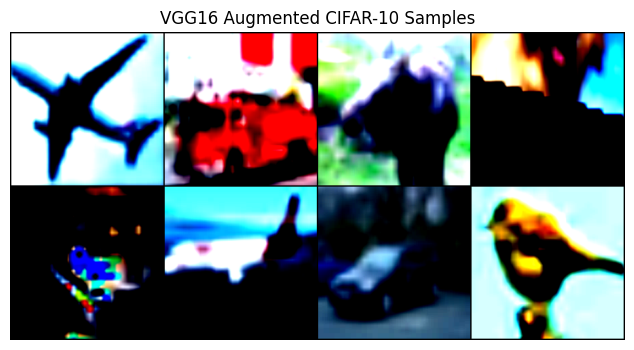

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


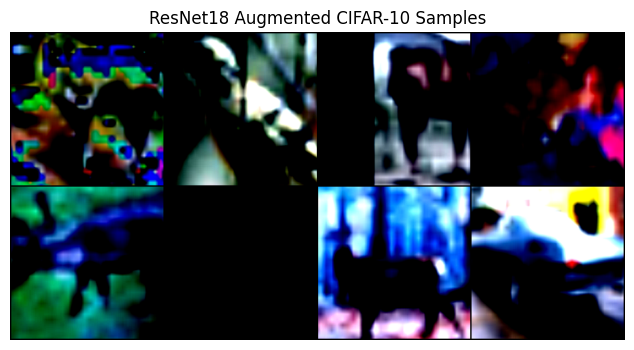

In [3]:
# load data

vgg_base_transforms = VGG16_Weights.DEFAULT.transforms()
resnet_base_transforms = ResNet18_Weights.DEFAULT.transforms()

vgg_transform = transforms.Compose([
    v2.AutoAugment(policy=v2.AutoAugmentPolicy.CIFAR10),
    v2.RandomHorizontalFlip(p=0.5),
    vgg_base_transforms,
])

resnet_transform = transforms.Compose([
    v2.AutoAugment(policy=v2.AutoAugmentPolicy.CIFAR10),
    v2.RandomHorizontalFlip(p=0.5),
    resnet_base_transforms,
])

# Loading data
full_train_vgg = torchvision.datasets.CIFAR10(root='./data',
                                              train=True,
                                              download=True,
                                              transform=vgg_transform)
full_test_vgg = torchvision.datasets.CIFAR10(root='./data',
                                             train=False,
                                             download=True,
                                             transform=vgg_transform)

full_train_resnet = torchvision.datasets.CIFAR10(root='./data',
                                                 train=True,
                                                 download=True,
                                                 transform=resnet_transform)
full_test_resnet = torchvision.datasets.CIFAR10(root='./data',
                                                train=False,
                                                download=True,
                                                transform=resnet_transform)

# Use 10% of data
train_size = int(0.1 * len(full_train_vgg))
test_size = int(0.1 * len(full_test_vgg))

train_subset_vgg, _ = torch.utils.data.random_split(full_train_vgg,
 [train_size, len(full_train_vgg) - train_size])
test_subset_vgg, _ = torch.utils.data.random_split(full_test_vgg,
 [test_size, len(full_test_vgg) - test_size])

train_subset_resnet, _ = torch.utils.data.random_split(full_train_resnet,
 [train_size, len(full_train_resnet) - train_size])
test_subset_resnet, _ = torch.utils.data.random_split(full_test_resnet,
 [test_size, len(full_test_resnet) - test_size])

# DataLoader
train_loader_vgg = DataLoader(train_subset_vgg, batch_size=64, shuffle=True)
test_loader_vgg = DataLoader(test_subset_vgg, batch_size=64, shuffle=False)

train_loader_resnet = DataLoader(train_subset_resnet, batch_size=64, shuffle=True)
test_loader_resnet = DataLoader(test_subset_resnet, batch_size=64, shuffle=False)

# Load your models and move them to the device
vgg_model = vgg16(weights=VGG16_Weights.DEFAULT).to(dml_device)
resnet_model = resnet18(weights=ResNet18_Weights.DEFAULT).to(dml_device)

# Verify transforms by visualizing VGG16-prepared images
def show_batch(loader, title):
    images, labels = next(iter(loader))
    img_grid = torchvision.utils.make_grid(images[:8], nrow=4)
    npimg = img_grid.numpy()
    plt.figure(figsize=(8, 4))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.axis("off")
    plt.show()

show_batch(train_loader_vgg, "VGG16 Augmented CIFAR-10 Samples")
show_batch(train_loader_resnet, "ResNet18 Augmented CIFAR-10 Samples")

Examine the CIFAR-10 images after applying transformations. Identify two classes you believe are most difficult for the models to distinguish and explain why.

**Written Answer:** I believe that the model struggles to distinguish horses and deers because of a similar shape and posture. These two classes have similar information for low resolution images, especially if the horse is a similar colour.

## Question 2: Model Definitions – VGG16 and ResNet18
1. Load pre-trained VGG16 and ResNet18 models from torchvision.
2. Freeze all convolutional layers initially, then unfreeze the last convolutional block in both models.
3. Modify the classifier layers to accommodate CIFAR-10 classification (10 output classes).

In [4]:
# VGG16 setup
vgg16 = models.vgg16(weights = models.VGG16_Weights.DEFAULT)

for param in vgg16.features.parameters(): # freeze
    param.requires_grad = False
for param in vgg16.features[24:].parameters(): # unfreeze
    param.requires_grad = True

vgg16.classifier[6] = nn.Linear(4096, 10)
vgg16_model = vgg16.to(dml_device)


# ResNet18 setup
resnet18 = models.resnet18(weights = models.ResNet18_Weights.DEFAULT)

for param in resnet18.parameters(): # freeze
    param.requires_grad = False
for param in resnet18.layer4.parameters(): # unfreeze
    param.requires_grad = True

resnet18.fc = nn.Linear(resnet18.fc.in_features, 10)
resnet18_model = resnet18.to(dml_device)


Explain the concept of transfer learning and its specific advantages when applied to CIFAR-10 classification using models like VGG16 and ResNet18.

**Written Answer:** Transfer learning takes a pre-trained model and uses it on new data like CIFAR-10 images. Since the model has already been trained, we can use it 'out of the box' rather than having to train an entire new model. By freezing early layers and fine-tuning later layers, we converge faster because the general features are in the early layers and the task-specific learning occurs in the unfrozen layers. This also improves performance with poor/limited datasets and reduces the training time.

## Question 3: Training the Models
1. Define the loss function (Cross-Entropy Loss).
2. Initialize Adam optimizers for each model with a learning rate of 0.001.
3. Train each model separately. Train for 5 epochs, monitor loss, and ensure proper updating of model weights.

In [5]:
# Training function
def train_model(model, train_loader, optimizer, criterion, epochs=5):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(dml_device), labels.to(dml_device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {running_loss / len(train_loader):.4f}")

In [6]:
# Train models
loss_fn = nn.CrossEntropyLoss()

optimizer_vgg = optim.Adam(filter(lambda p: p.requires_grad,
                                  vgg16.parameters()), lr = 0.001)
optimizer_resnet = optim.Adam(filter(lambda p: p.requires_grad,
                                     resnet18.parameters()), lr = 0.001)

print("VGG16:\n")
train_model(vgg16, train_loader_vgg, optimizer_vgg, loss_fn)

print("ResNet18:")
train_model(resnet18, train_loader_resnet, optimizer_resnet, loss_fn)

VGG16:



c:\Users\Andy Yuan\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\optim\adam.py:534: UserWarning: The operator 'aten::lerp.Scalar_out' is not currently supported on the DML backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at C:\__w\1\s\pytorch-directml-plugin\torch_directml\csrc\dml\dml_cpu_fallback.cpp:17.)
  torch._foreach_lerp_(device_exp_avgs, device_grads, 1 - beta1)


Epoch 1, Loss: 2.1322
Epoch 2, Loss: 1.7256
Epoch 3, Loss: 1.5058
Epoch 4, Loss: 1.3627
Epoch 5, Loss: 1.2697
ResNet18:
Epoch 1, Loss: 1.0807
Epoch 2, Loss: 0.8018
Epoch 3, Loss: 0.6512
Epoch 4, Loss: 0.6067
Epoch 5, Loss: 0.5506


Compare training behaviours of VGG16 and ResNet18. Which model trains faster and why?

**Written Answer:** ResNet18 trained faster than VGG16 because ResNet18 has less parameters and residual connections. VGG16 is also denser, which means it goes deeper, usually slowing training and increases computations.

## Question 4: Model Evaluation
1. Define a function to calculate the accuracy of each model on the test set.
2. Evaluate both models separately.
3. Plot confusion matrices for each model using `sklearn.metrics.confusion_matrix` and `ConfusionMatrixDisplay`.
4. Interpret results based on model-specific accuracy and confusion matrix insights.


VGG16 Test Accuracy: 59.00%
VGG16 Test Loss: 1.1771


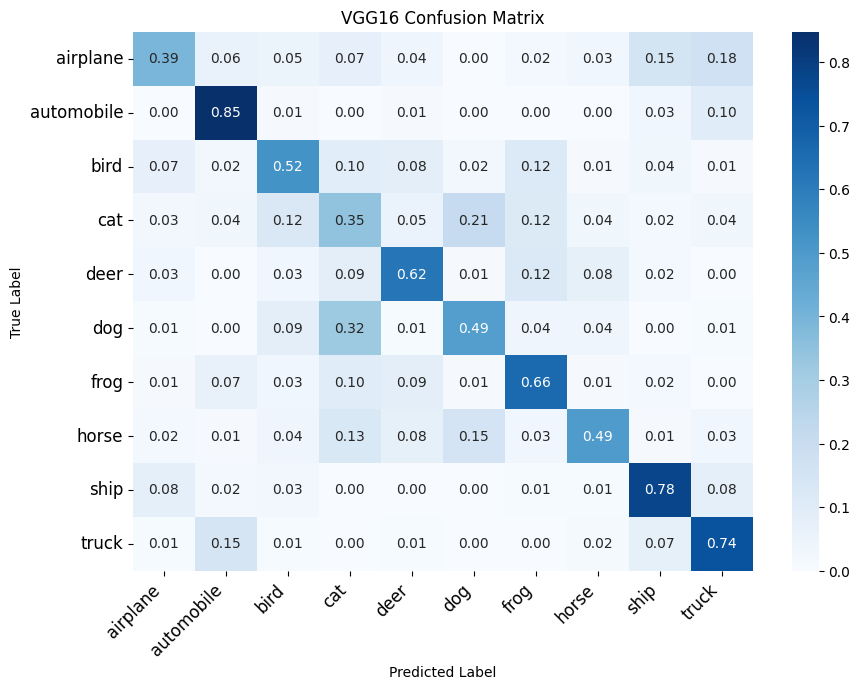


ResNet18 Test Accuracy: 74.00%
ResNet18 Test Loss: 0.7915


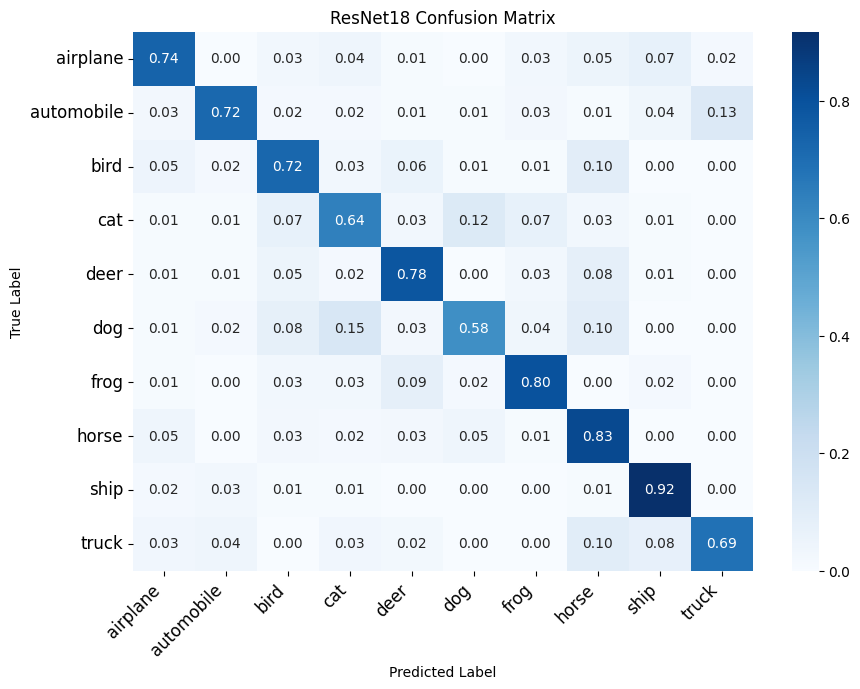

In [7]:
# Evaluation & confusion matrix
# CIFAR-10 class labels
cifar10_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                   'dog', 'frog', 'horse', 'ship', 'truck']

def evaluate_model(model, test_loader, loss_fn, dml_device, model_name="Model"):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    test_labels = np.array([])
    test_predictions = np.array([])

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(dml_device), labels.to(dml_device)
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)

            _, preds = torch.max(outputs, 1)

            test_labels = np.append(test_labels, labels.cpu().numpy())
            test_predictions = np.append(test_predictions, preds.cpu().numpy())

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

    test_loss = running_loss / len(test_loader.dataset)
    test_acc = running_corrects.float() / len(test_loader.dataset)

    print(f"\n{model_name} Test Accuracy: {test_acc * 100:.2f}%")
    print(f"{model_name} Test Loss: {test_loss:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_true=test_labels, y_pred=test_predictions)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Convert to DataFrame
    df_cm = pd.DataFrame(
        cm_normalized,
        index=cifar10_classes,
        columns=cifar10_classes,
    )

    # Plot heatmap
    plt.figure(figsize=(10, 7))
    heatmap = sns.heatmap(df_cm, annot=True, fmt='.2f', cmap='Blues')
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0,
                                 ha='right', fontsize=12)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45,
                                 ha='right', fontsize=12)
    plt.title(f'{model_name} Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    return test_acc.item(), test_loss, cm_normalized

# Evaluate VGG16
vgg_acc, vgg_loss, vgg_cm = evaluate_model(vgg16_model, test_loader_vgg, loss_fn,
                                           dml_device, model_name="VGG16")

# Evaluate ResNet18
resnet_acc, resnet_loss, resnet_cm = evaluate_model(resnet18_model,
                                                    test_loader_resnet,
                                                    loss_fn,
                                                    dml_device,
                                                    model_name="ResNet18")

Suggest two additional improvements specifically tailored for the less accurate model. Clearly explain your rationale for each suggestion.

**Written Answer:** The less accurate model was the VGG16 model. 

- Data augmentation like flipping or stretching the model would improve the model's understanding of the various cases. This is because photos are not necessarily correct or immediately identifiable with a small number of attributes or perspectives
- Fine-tuning deeper layers would increase accuracy because deeper features can be extracted better. Or, you could implement more hidden layers. Both approaches make it easier to distinguish more features.